# Gojek Bootcamp Day 2: Session 4 Part 3 Boosting from scratch

In this part of session we are going to implement live one specific implementation type of boosting, which is adaboost. As have been explained in the session before, boosting is trained by iteratively train a weak classifier and then combined the prediction score from many classifier into one

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('medium_dataset.csv')
df.head()

,x,y,label
0,0.471969,0.290023,0
1,-0.647295,-0.637178,0
2,-0.551973,-1.019000,0
3,-0.150224,0.636008,0
4,-0.335839,0.642716,0


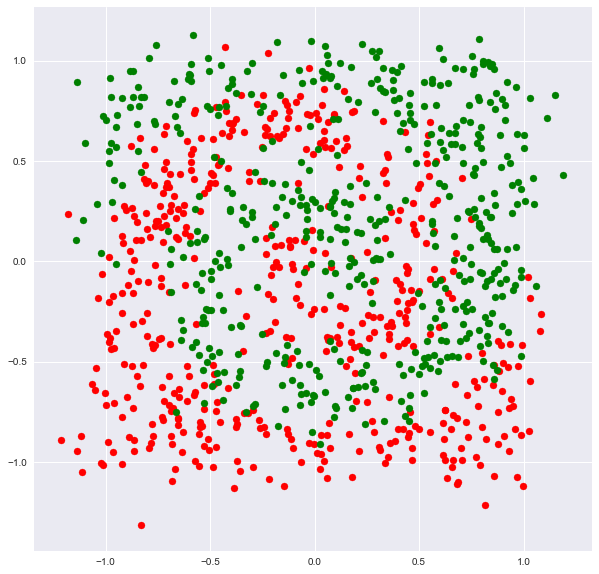

In [3]:
def plot_dataset(df, ax=None):
    
    ax.scatter(x='x', y='y', data=df[df['label'] == 0], color='red')
    ax.scatter(x='x', y='y', data=df[df['label'] == 1], color='green')

fig, ax = plt.subplots(figsize=(10, 10))
plot_dataset(df, ax=ax)

Our weak classifier will be decision tree with depth of only 1, sometimes also called decision stump.

This actually can be of any classifier, but because the process is performed iteratively, we must balance between speed and accuracy

In [12]:
from sklearn.tree import DecisionTreeClassifier

def weak_learn(X, y, weight):

    model = DecisionTreeClassifier(max_depth=1, criterion='entropy')
    model.fit(X, y, sample_weight=weight)

    err = np.sum((model.predict(X) != y) * weight)
    
    return model, err

In [13]:
X = df[['x', 'y']]
y = df['label']*2-1
weight = np.array([1./len(y)]*len(y))

models = []
alphas = []

n_iter = 100

# fig, axes = plt.subplots(n_iter/2, 2, figsize=(n_iter, n_iter))

for i in range(n_iter):
    model, err = weak_learn(X, y, weight)
    alpha = np.log((1-err) / err)
    
    models += [model]
    alphas += [alpha]
    
#     ax = axes.reshape(-1)[i]
#     decision_boundary(model, df, ax)
    
    weight = weight * np.exp((model.predict(X) != y) * alpha)
    weight = (weight / np.sum(weight)).values

In [14]:
def predict(models, alphas, X):
    
    score = 0
    
    for model, alpha in zip(models, alphas):
        
        score += model.predict(X)*alpha
        
    return int(score > 0)

In [15]:
def decision_boundary(model, df, ax=None):
    
    max_x = np.max(df['x'])
    max_y = np.max(df['y'])
    
    min_x = np.min(df['x'])
    min_y = np.min(df['y'])
    
    res = 100
    xs = np.linspace(min_x, max_x, res)
    ys = np.linspace(min_y, max_y, res)
    zs = np.zeros((res, res))

    for i,x in enumerate(xs):
        for j,y in enumerate(ys):
            zs[j, i] = model.predict(np.array([[x, y]]))

    ax.contour(xs, ys, zs, levels=(-1, 0, 1), linewidths=2, colors='black', alpha=0.5)
    ax.contourf(xs, ys, zs, levels=(-1, 0, 1), colors=('#ff0000', '#00ff00'), alpha=0.2)

    ax.scatter(x='x', y='y', data=df[df['label'] == 0], color='red', s=4)
    ax.scatter(x='x', y='y', data=df[df['label'] == 1], color='green', s=4)
    
    ax.set_xlim((min_x, max_x))
    ax.set_ylim((min_y, max_y))

In [16]:
def decision_boundary2(df, ax=None):
    
    max_x = np.max(df['x'])
    max_y = np.max(df['y'])
    
    min_x = np.min(df['x'])
    min_y = np.min(df['y'])
    
    res = 100
    xs = np.linspace(min_x, max_x, res)
    ys = np.linspace(min_y, max_y, res)
    zs = np.zeros((res, res))

    for i,x in enumerate(xs):
        for j,y in enumerate(ys):
            zs[j, i] = predict(models, alphas, np.array([[x, y]]))

    ax.contour(xs, ys, zs, levels=(-1, 0, 1), linewidths=2, colors='black', alpha=0.5)
    ax.contourf(xs, ys, zs, levels=(-1, 0, 1), colors=('#ff0000', '#00ff00'), alpha=0.2)

    ax.scatter(x='x', y='y', data=df[df['label'] == 0], color='red', s=4)
    ax.scatter(x='x', y='y', data=df[df['label'] == 1], color='green', s=4)
    
    ax.set_xlim((min_x, max_x))
    ax.set_ylim((min_y, max_y))

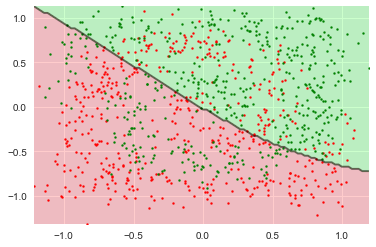

In [17]:
fig, ax = plt.subplots()

decision_boundary2(df, ax)

Intermezzo, all that we've done can be in 3 lines using scikit-learn libraries

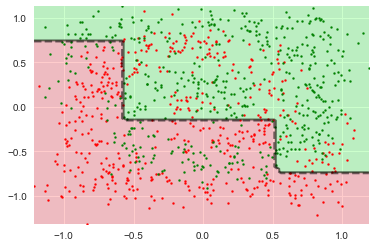

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(max_depth=1, n_estimators=50)
gbc.fit(X, y)

fig, ax = plt.subplots()
decision_boundary(gbc, df, ax)